TRAIN MODEL

Mean Absolute Percentage Error (MAPE): 0.21
Mean Absolute Error (MAE): 603729938.69
Root Mean Squared Error (RMSE): 1521760686.49
R-squared (R²): 0.91


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


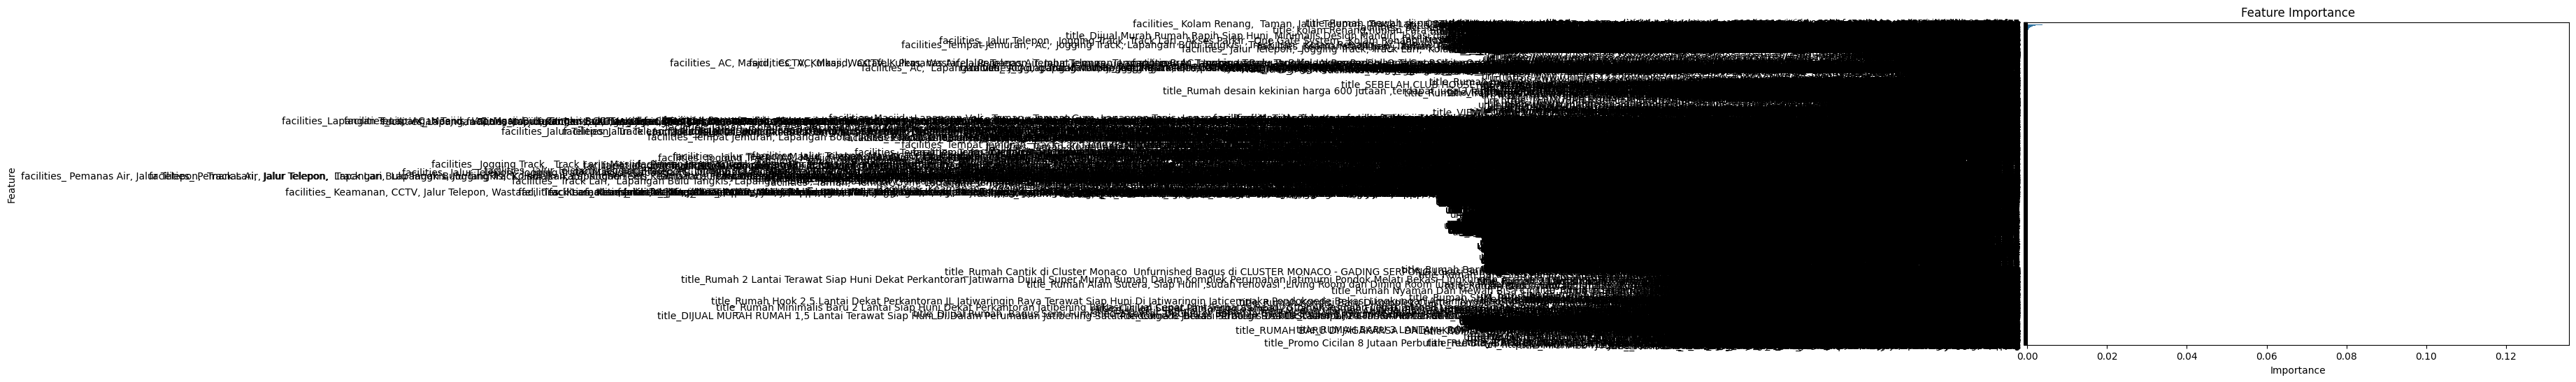

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score
import numpy as np

# Membaca dataset
dataset = pd.read_csv("jabodetabek_house_price.csv")

# Pembersihan dan preprocessing data
dataset.drop(['ads_id'], axis=1, inplace=True)  # Menghapus kolom yang tidak diperlukan
dataset['price_in_rp'] = dataset['price_in_rp'].fillna(dataset['price_in_rp'].mean())  # Mengisi nilai hilang
new_dataset = dataset.dropna()  # Menghapus baris dengan nilai hilang

# Feature Engineering: Menambahkan fitur baru
#new_dataset['building_to_land_ratio'] = new_dataset['building_size_m2'] / new_dataset['land_size_m2']

# Memisahkan fitur dan target
X = new_dataset.drop('price_in_rp', axis=1)
y = new_dataset['price_in_rp']

# Preprocessing
# Imputasi dan normalisasi fitur numerik
numerical_features = ['lat', 'long', 'bedrooms', 'bathrooms', 'land_size_m2', 'building_size_m2',
                      'carports', 'maid_bedrooms', 'maid_bathrooms', 'floors', 'building_age',
                      'year_built', 'garages']

imputer = SimpleImputer(strategy='mean')
X[numerical_features] = imputer.fit_transform(X[numerical_features])

scaler = StandardScaler()
X[numerical_features] = scaler.fit_transform(X[numerical_features])

# Encoding fitur kategorikal
object_cols = X.select_dtypes(include=['object']).columns
OH_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
OH_cols = pd.DataFrame(OH_encoder.fit_transform(X[object_cols]))
OH_cols.index = X.index
OH_cols.columns = OH_encoder.get_feature_names_out()

X = pd.concat([X.drop(object_cols, axis=1), OH_cols], axis=1)

# Membagi data menjadi set pelatihan dan validasi
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)

# Hyperparameter Tuning menggunakan Grid Search
model_XGB = XGBRegressor(random_state=0)
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7, 9],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

grid_search = GridSearchCV(model_XGB, param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Menggunakan model terbaik dari Grid Search
best_model = grid_search.best_estimator_

# Evaluasi model
y_pred = best_model.predict(X_valid)

# Menghitung metrik evaluasi
mape = mean_absolute_percentage_error(y_valid, y_pred)
mae = mean_absolute_error(y_valid, y_pred)
rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
r2 = r2_score(y_valid, y_pred)

print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-squared (R²): {r2:.2f}")

# Feature Importance Analysis
importances = best_model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Visualisasi feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance')
plt.show()

VISUAL

url                      object
price_in_rp             float64
title                    object
address                  object
district                 object
city                     object
lat                     float64
long                    float64
facilities               object
property_type            object
bedrooms                float64
bathrooms               float64
land_size_m2            float64
building_size_m2        float64
carports                float64
certificate              object
electricity              object
maid_bedrooms           float64
maid_bathrooms          float64
floors                  float64
building_age            float64
year_built              float64
property_condition       object
building_orientation     object
garages                 float64
furnishing               object
dtype: object


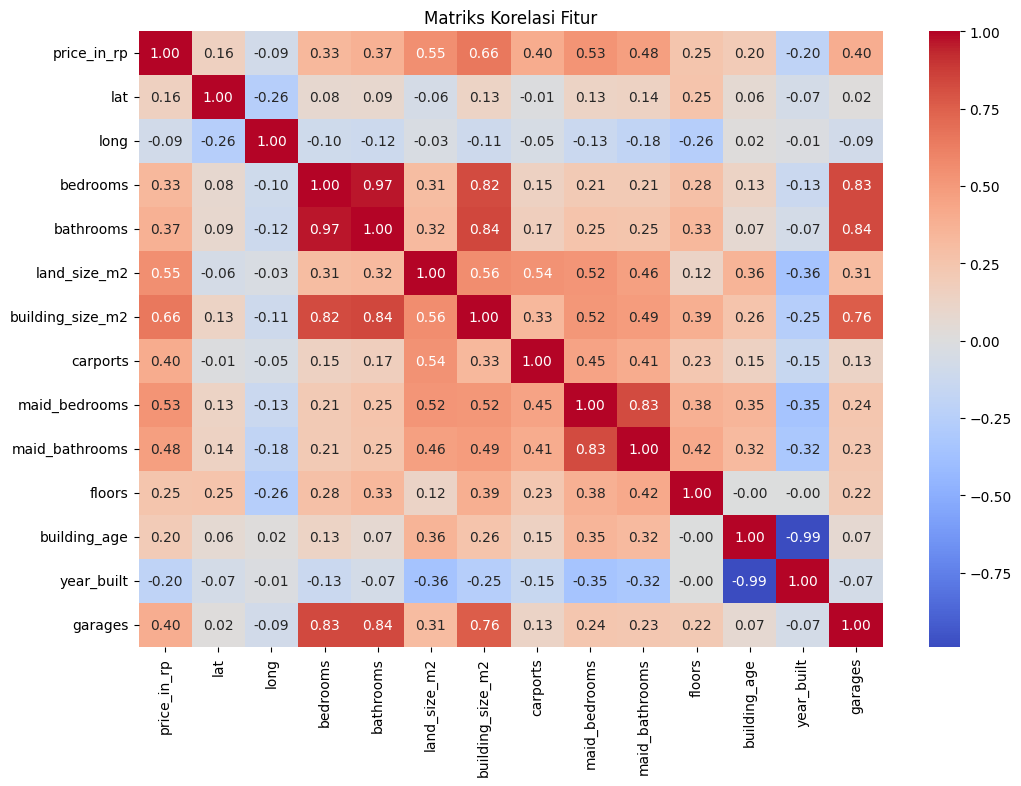

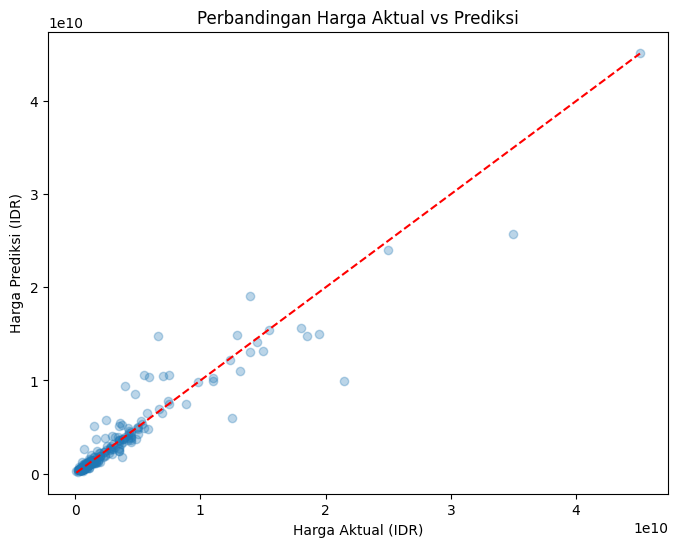

In [3]:
# Memeriksa tipe data
print(new_dataset.dtypes)

# Menghapus kolom yang tidak relevan (misalnya, kolom dengan tipe objek)
# Hanya menyimpan kolom numerik for correlation analysis
numerical_data = new_dataset.select_dtypes(include=[np.number])


# Visualisasi Korelasi Fitur
plt.figure(figsize=(12, 8))
correlation_matrix = numerical_data.corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Matriks Korelasi Fitur')
plt.show()

# Visualisasi Actual vs Predicted
plt.figure(figsize=(8, 6))
plt.scatter(y_valid, y_pred, alpha=0.3)
plt.plot([y_valid.min(), y_valid.max()], [y_valid.min(), y_valid.max()], 'r--')
plt.xlabel('Harga Aktual (IDR)')
plt.ylabel('Harga Prediksi (IDR)')
plt.title('Perbandingan Harga Aktual vs Prediksi')
plt.show()

In [4]:
dataset.shape

(3553, 26)

SIMPAN MODEL

In [5]:
import pickle

# Simpan model XGBoost
with open("xgb_model_fixed.pkl", "wb") as f:
    pickle.dump(best_model, f)

# Simpan OneHotEncoder
with open("oh_encoder_fixed.pkl", "wb") as f:
    pickle.dump(OH_encoder, f)

# Simpan StandardScaler
with open("scaler_fixed.pkl", "wb") as f:
    pickle.dump(scaler, f)

# Simpan daftar kolom kategorikal
with open("object_cols_fixed.pkl", "wb") as f:
    pickle.dump(object_cols, f)

# Simpan urutan kolom input (penting agar urutan saat prediksi sesuai)
with open("X_train_columns_fixed.pkl", "wb") as f:
    pickle.dump(X_train.columns.tolist(), f)

print("Semua file model dan encoder berhasil disimpan.")

Semua file model dan encoder berhasil disimpan.


FUNGSI PREDIKSI BERDASARKAN INPUT USER

In [6]:
# Cell 1: Import library
import numpy as np
import pandas as pd
import pickle

# Cell 2: Load model dan objek preprocessing
with open("xgb_model_fixed.pkl", "rb") as f:
    model = pickle.load(f)

with open("scaler_fixed.pkl", "rb") as f:
    scaler = pickle.load(f)

with open("oh_encoder_fixed.pkl", "rb") as f:
    oh_encoder = pickle.load(f)

with open("object_cols_fixed.pkl", "rb") as f:
    object_cols = pickle.load(f)

with open("X_train_columns_fixed.pkl", "rb") as f:
    final_columns = pickle.load(f)
def predict_house_price(input_dict):
    df = pd.DataFrame([input_dict])

    # Buang kolom-kolom yang tidak digunakan saat training
    unused_cols = set(df.columns) - set(object_cols) - set(final_columns)
    df.drop(columns=list(unused_cols), inplace=True, errors='ignore')

    # Daftar fitur numerik seperti saat training
    numerical_features = [
        'lat', 'long', 'bedrooms', 'bathrooms', 'land_size_m2', 'building_size_m2',
        'carports', 'maid_bedrooms', 'maid_bathrooms', 'floors',
        'building_age', 'year_built', 'garages'
    ]

    # Cek apakah semua fitur numerik ada
    for col in numerical_features:
        if col not in df.columns:
            df[col] = 0  # default jika tidak diisi

    # Transformasi numerik
    df[numerical_features] = scaler.transform(df[numerical_features])

    # Encoding fitur kategorikal
    for col in object_cols:
        if col not in df.columns:
            df[col] = "unknown"  # nilai default jika tidak ada

    cat_df = df[object_cols]
    cat_encoded = pd.DataFrame(oh_encoder.transform(cat_df), columns=oh_encoder.get_feature_names_out())
    cat_encoded.index = df.index

    # Gabung semua
    df = pd.concat([df.drop(columns=object_cols), cat_encoded], axis=1)

    # Tambahkan kolom yang mungkin hilang agar urutannya cocok
    for col in final_columns:
        if col not in df.columns:
            df[col] = 0

    # Pastikan urutan kolom sesuai saat training
    df = df[final_columns]
    # Prediksi
    prediction = model.predict(df)[0]
    return prediction

In [7]:
# Contoh input data dari pengguna
input_data = {
    'lat': -6.1766875,
    'long': 106.650034,
    'bedrooms': 6,
    'bathrooms': 3,
    'land_size_m2': 180,
    'building_size_m2': 140,
    'carports': 1,
    'maid_bedrooms': 0,
    'maid_bathrooms': 0,
    'floors': 2,
    'garages': 1,
    'title': 'Rumah Di Tanggerang Dekat Tol Karawaci 1 Idaman Muslim Dekat Masjid View Danau',
    'address': 'Tangerang Kota, Tangerang',
    'district': 'Tangerang Kota',
    'city': 'Tangerang',
    'facilities': 'Masjid,  Taman, Tempat Jemuran, Lapangan Bulu Tangkis, Kitchen Set, Keamanan 24 jam, Wastafel, Track Lari, Taman,  One Gate System',
    'property_type': 'rumah',
    'certificate': 'shm',
    'electricity': '2200 VA',
    'property_condition': 'bagus',
    'year_built': 2020,
    'building_age': 2,
    'building_orientation': 'utara',
    'furnishing': 'semi-furnished',
    'url': 'placeholder-url'
}

# Panggil fungsi prediksi
predicted_price = predict_house_price(input_data)

# Tampilkan hasil prediksi
print(f"Harga rumah diprediksi: Rp {predicted_price:,.0f}")


Harga rumah diprediksi: Rp 3,105,566,464


In [ ]:
# Cell 1: Import library
import numpy as np
import pandas as pd
import pickle

# Cell 2: Load model dan objek preprocessing
with open("xgb_model1.pkl", "rb") as f:
    model = pickle.load(f)

with open("scaler1.pkl", "rb") as f:
    scaler = pickle.load(f)

with open("oh_encoder1.pkl", "rb") as f:
    oh_encoder = pickle.load(f)

with open("object_cols1.pkl", "rb") as f:
    object_cols = pickle.load(f)

with open("X_train_columns.pkl", "rb") as f:
    final_columns = pickle.load(f)

# Cell 3: Buat fungsi prediksi
def predict_house_price(input_dict):
    """
    Menerima input pengguna dalam bentuk dictionary.
    Contoh:
    {
        'lat': -6.2,
        'long': 106.8,
        'bedrooms': 3,
        'bathrooms': 2,
        'land_size_m2': 100,
        'building_size_m2': 120,
        'carports': 1,
        'maid_bedrooms': 0,
        'maid_bathrooms': 0,
        'floors': 2,
        'garages': 1,
        'provinsi': 'DKI Jakarta',
        'kota': 'Jakarta Selatan',
        'kecamatan': 'Kebayoran Baru',
        ...
    }
    """

    df = pd.DataFrame([input_dict])



    # Pisahkan numerik dan kategorikal
    numerical_features = ['lat', 'long', 'bedrooms', 'bathrooms', 'land_size_m2', 'building_size_m2',
                      'carports', 'maid_bedrooms', 'maid_bathrooms', 'floors', 'building_age',
                      'year_built', 'garages']

    cat_cols = object_cols

    # Preprocessing numerik
    df[numerical_features] = scaler.transform(df[numerical_features])

    # Preprocessing kategorikal
    cat_df = df[cat_cols]
    cat_encoded = pd.DataFrame(oh_encoder.transform(cat_df), columns=oh_encoder.get_feature_names_out())
    cat_encoded.index = df.index

    # Gabungkan
    df = pd.concat([df.drop(cat_cols, axis=1), cat_encoded], axis=1)

    # Urutkan kolom sesuai saat training
    for col in final_columns:
        if col not in df.columns:
            df[col] = 0  # jika kolom tidak muncul di input, isi 0

    df = df[final_columns]

    # Prediksi
    prediction = model.predict(df)[0]
    return prediction


In [ ]:
input_data = {
    'lat': -6.1766875,
    'long': 106.650034,
    'bedrooms': 6,
    'bathrooms': 3,
    'land_size_m2': 180,
    'building_size_m2': 140,
    'carports': 1,
    'maid_bedrooms': 0,
    'maid_bathrooms': 0,
    'floors': 2,
    'garages': 1,
    'title': 'Rumah Di Tanggerang Dekat Tol Karawaci 1 Idaman Muslim Dekat Masjid View Danau',
    'address': 'Tangerang Kota, Tangerang',
    'district': 'Tangerang Kota',
    'city': 'Tangerang',
    'facilities': 'Masjid,  Taman, Tempat Jemuran, Lapangan Bulu Tangkis, Kitchen Set, Keamanan 24 jam, Wastafel, Track Lari, Taman,  One Gate System',
    'property_type': 'rumah',
    'certificate': 'shm',
    'electricity': '2200 VA',
    'property_condition': 'bagus',
    'building_orientation': 'utara',
    'furnishing': 'semi-furnished',
    'url': 'placeholder-url'
}

predicted_price = predict_house_price(input_data)
print(f"Harga rumah diprediksi: Rp {predicted_price:,.0f}")


Harga rumah diprediksi: Rp 3,105,566,464


In [5]:
# Cell 1: Import library
import numpy as np
import pandas as pd
import pickle

# Cell 2: Load model dan objek preprocessing
with open("xgb_model1.pkl", "rb") as f:
    model = pickle.load(f)

with open("scaler1.pkl", "rb") as f:
    scaler = pickle.load(f)

with open("oh_encoder1.pkl", "rb") as f:
    oh_encoder = pickle.load(f)

with open("object_cols1.pkl", "rb") as f:
    object_cols = pickle.load(f)

with open("X_train_columns1.pkl", "rb") as f:
    final_columns = pickle.load(f)

# Cell 3: Buat fungsi prediksi
def predict_house_price(input_dict):
    """
    Menerima input pengguna dalam bentuk dictionary.
    Contoh:
    {
        'lat': -6.2,
        'long': 106.8,
        'bedrooms': 3,
        'bathrooms': 2,
        'land_size_m2': 100,
        'building_size_m2': 120,
        'carports': 1,
        'maid_bedrooms': 0,
        'maid_bathrooms': 0,
        'floors': 2,
        'garages': 1,
        'provinsi': 'DKI Jakarta',
        'kota': 'Jakarta Selatan',
        'kecamatan': 'Kebayoran Baru',
        ...
    }
    """

    df = pd.DataFrame([input_dict])



    # Pisahkan numerik dan kategorikal
    numerical_features = ['lat', 'long', 'bedrooms', 'bathrooms', 'land_size_m2', 'building_size_m2',
                      'carports', 'maid_bedrooms', 'maid_bathrooms', 'floors', 'building_age',
                      'year_built', 'garages']

    cat_cols = object_cols

    # Preprocessing numerik
    df[numerical_features] = scaler.transform(df[numerical_features])

    # Preprocessing kategorikal
    cat_df = df[cat_cols]
    cat_encoded = pd.DataFrame(oh_encoder.transform(cat_df), columns=oh_encoder.get_feature_names_out())
    cat_encoded.index = df.index

    # Gabungkan
    df = pd.concat([df.drop(cat_cols, axis=1), cat_encoded], axis=1)

    # Urutkan kolom sesuai saat training
    for col in final_columns:
        if col not in df.columns:
            df[col] = 0  # jika kolom tidak muncul di input, isi 0

    df = df[final_columns]

    # Prediksi
    prediction = model.predict(df)[0]
    return prediction

input_data = {
    'lat': -6.1766875,
    'long': 106.650034,
    'bedrooms': 6,
    'bathrooms': 3,
    'land_size_m2': 180,
    'building_size_m2': 140,
    'carports': 1,
    'maid_bedrooms': 0,
    'maid_bathrooms': 0,
    'floors': 2,
    'garages': 1,
    'title': 'Rumah Di Tanggerang Dekat Tol Karawaci 1 Idaman Muslim Dekat Masjid View Danau',
    'address': 'Tangerang Kota, Tangerang',
    'district': 'Tangerang Kota',
    'city': 'Tangerang',
    'facilities': 'Masjid,  Taman, Tempat Jemuran, Lapangan Bulu Tangkis, Kitchen Set, Keamanan 24 jam, Wastafel, Track Lari, Taman,  One Gate System',
    'property_type': 'rumah',
    'certificate': 'shm',
    'electricity': '2200 VA',
    'property_condition': 'bagus',
    'year_built': 2020,
    'building_age': 2,
    'building_orientation': 'utara',
    'furnishing': 'semi-furnished',
    'url': 'placeholder-url'
}

predicted_price = predict_house_price(input_data)
print(f"Harga rumah diprediksi: Rp {predicted_price:,.0f}")



Harga rumah diprediksi: Rp 3,105,566,464
